In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import meet
import helper_scripts.helper_functions as helper_functions
import matplotlib.mlab as mlab
from scipy import signal as sig
import tables

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['savefig.dpi'] = 600

In [2]:
# select subject

subject = 'S1'
measurement_type = 'MEG'
additional_name = ''

data_folder = '../Data'
results_main_folder = '../Results'

additional_plot_title = ''

#remove_powerline_filter_type = 'none'
#remove_powerline_filter_type = 'notch'
#remove_powerline_filter_type = 'PLI'
remove_powerline_filter_type = 'spectrum_notch'

# use brownian noise to make a reference model
if(subject.endswith('BN')):
    use_brown_noise = True
else:
    use_brown_noise = False

if(use_brown_noise):
    results_folder = os.path.join(results_main_folder, subject+'_brown_noise')
    subject_name = subject+'_'+measurement_type+'_brown_noise'
else:
    results_folder = os.path.join(results_main_folder, subject+'_'+measurement_type+'_only')
    subject_name = subject+'_'+measurement_type+'_only'


if(measurement_type == 'MEG'):

    srate = 20000
    unit = 'B [fT]'
    asd_unit = '[fT/√HZ]'

elif(measurement_type == 'EEG'):

    srate = 10000
    unit = 'U [μV]'
    asd_unit = '[μV/√HZ]'


if(use_brown_noise):
    filename = 'S1_MEG_stim.dat'
    raw_data_stim = helper_functions.readMEG(os.path.join(data_folder, 'S1', filename), s_rate=srate, num_chans=2)
    raw_data_rest = []
elif(measurement_type == 'MEG'):
    filename = '%s_MEG_only_stim.dat' % subject
    raw_data_stim = helper_functions.readMEG(os.path.join(data_folder, subject, filename), s_rate=srate, num_chans=2)
    filename = '%s_MEG_only_relax.dat' % subject
    raw_data_rest = helper_functions.readMEG(os.path.join(data_folder, subject, filename), s_rate=srate, num_chans=2)
elif(measurement_type == 'EEG'):
    filename = '%s_EEG_only_stim.hdf5' % subject
    h5file_eeg_stim = tables.open_file(os.path.join(data_folder, subject, filename), mode="r", title="%s_eeg_stim" % subject)
    raw_data_stim = np.array(h5file_eeg_stim.root.EEG_data).T
    filename = '%s_EEG_only_rest.hdf5' % subject
    h5file_eeg_rest = tables.open_file(os.path.join(data_folder, subject, filename), mode="r", title="%s_eeg_rest" % subject)
    raw_data_rest = np.array(h5file_eeg_rest.root.EEG_data).T
results_path = results_folder

In [3]:
if(measurement_type == 'EEG'):
    offset = 38
    XEG_data = raw_data_stim[0][5*srate+offset:]
    stimulus_data = raw_data_stim[-1][5*srate:-offset]
    XEG_rest_data = raw_data_rest[0][5*srate:]
else:
    XEG_data = -raw_data_stim[0]
    stimulus_data = raw_data_stim[-1]
    XEG_rest_data = raw_data_rest[0]

In [4]:
if(use_brown_noise):
    # use brownian noise as a reference model
    import colorednoise as cn
    if(measurement_type == 'EEG'):
        XEG_data = 1000*cn.powerlaw_psd_gaussian(2, len(XEG_data))
    else:
        XEG_data = 10000*cn.powerlaw_psd_gaussian(2, len(XEG_data))

In [5]:
def plt_header(main_title=''):

    title = subject_name
    title += '\n'+main_title+additional_plot_title

    plt.title(title)

In [6]:
def plt_show_save_fig(fig_name=None):

    if(fig_name):
        fig_name += '.png'
    else:
        plt_show_save_fig.counter += 1
        fig_name = 'Fig%02d.png' % plt_show_save_fig.counter

    print('--------------------\n'+fig_name)
    os.makedirs(results_path, exist_ok=True)
    plt.savefig(os.path.join(results_path, fig_name), bbox_inches='tight')
    plt.show()

plt_show_save_fig.counter = 0

--------------------
Fig01.png


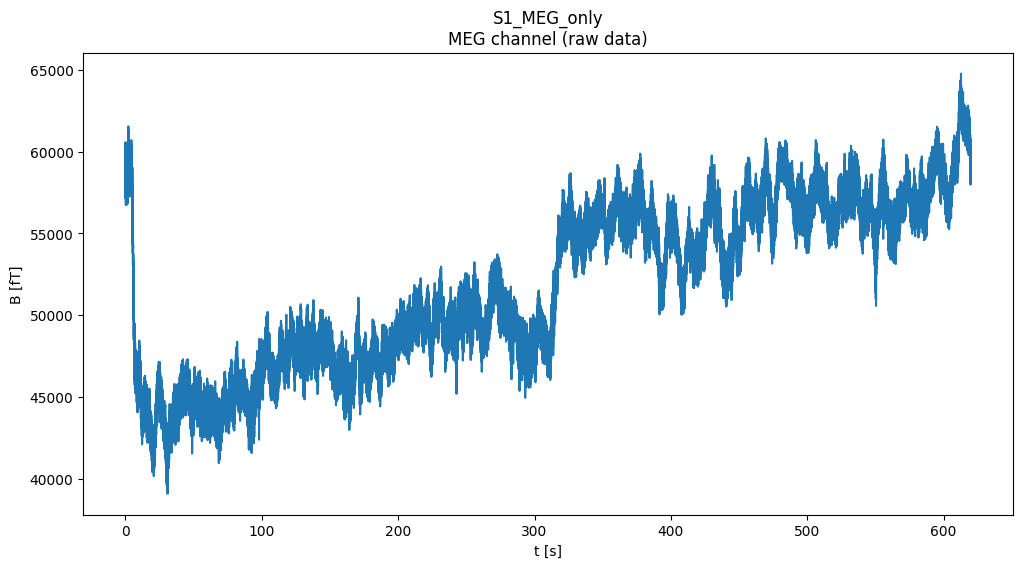

In [7]:
data = XEG_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s channel (raw data)' % (measurement_type))
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()

--------------------
Fig02.png


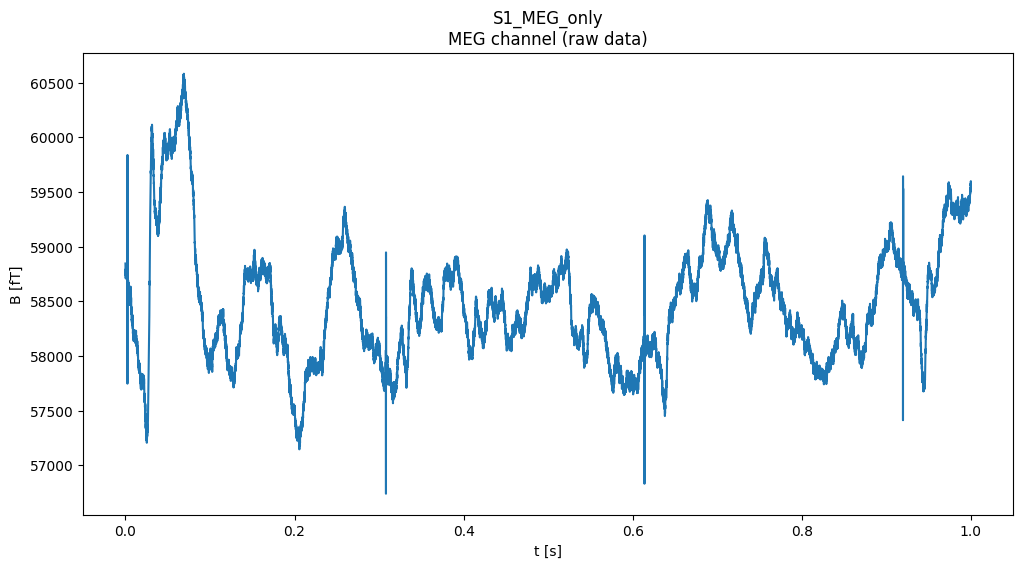

--------------------
Fig03.png


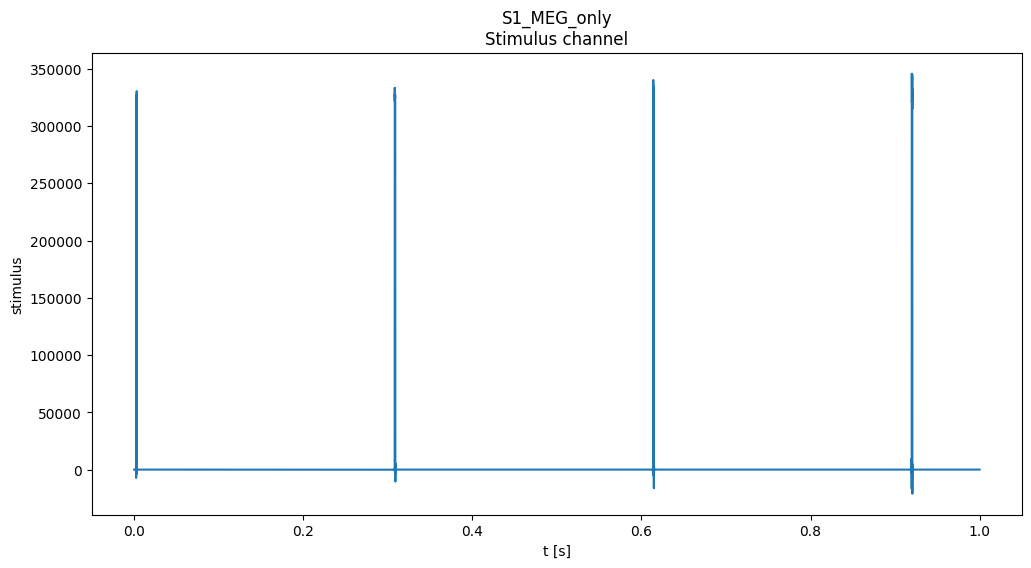

--------------------
Fig04.png


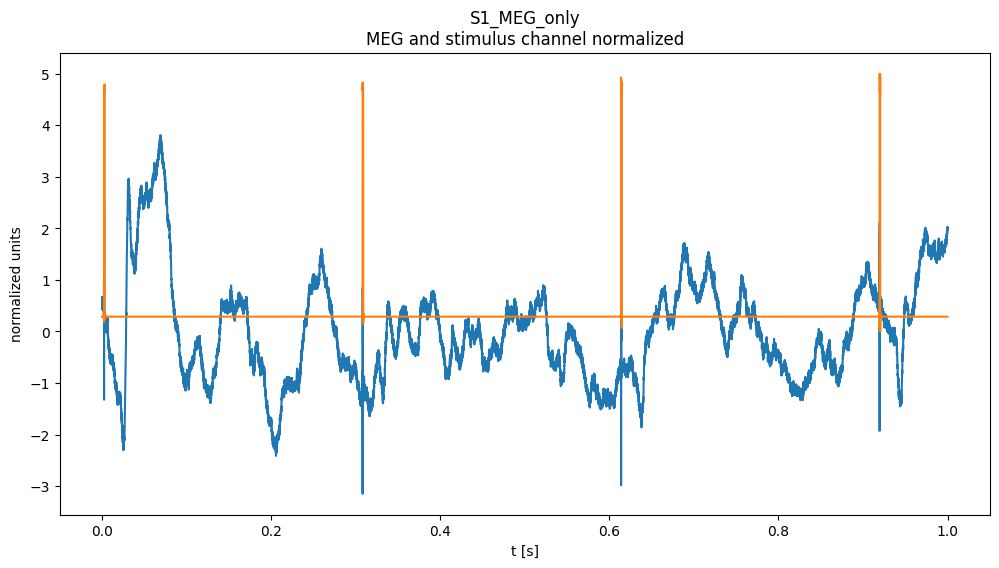

In [8]:
data = XEG_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s channel (raw data)' % (measurement_type))
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()

data = stimulus_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('Stimulus channel')
plt.plot(data_x, data_y)
plt.xlabel('t [s]')
plt.ylabel('stimulus')
plt_show_save_fig()

data = XEG_data[:srate]
data = data - np.mean(data)
data = data / np.std(data)
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt_header('%s and stimulus channel normalized' % (measurement_type))
plt.plot(data_x, data_y, label='MEG channel')
plt.xlabel('t [s]')
plt.ylabel('stimulus')

data = stimulus_data[:srate]
data = data - np.min(data)
data = data / np.max(data)
data *= 5
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data

plt.plot(data_x, data_y, label='stimulus channel')
plt.xlabel('t [s]')
plt.ylabel('normalized units')
plt_show_save_fig()

In [9]:
# get the stimuli positions
if(measurement_type == 'MEG'):
    all_stimuli = ((stimulus_data[1:]>250000) & (stimulus_data[:-1]<250000)).nonzero()[0]
elif(measurement_type == 'EEG'):
    all_stimuli = ((stimulus_data[1:]>0.5) & (stimulus_data[:-1]<0.5)).nonzero()[0]

# get the marker, omit the first and last (avoid edge effects)
marker = all_stimuli[1:-1]

In [10]:
'''
new_stimulus_freq = 5 # Hz

all_stimuli = (np.arange(new_stimulus_freq*len(stimulus_data)/srate)*(srate/new_stimulus_freq)+50).astype(int)
marker = all_stimuli[1:-1]
'''

'\nnew_stimulus_freq = 5 # Hz\n\nall_stimuli = (np.arange(new_stimulus_freq*len(stimulus_data)/srate)*(srate/new_stimulus_freq)+50).astype(int)\nmarker = all_stimuli[1:-1]\n'

In [11]:
# interpolate the stimuli
if(measurement_type == 'EEG'):
    interpolate_win_ms = [-5, 5]
else:
    interpolate_win_ms = [-2, 3]
interpolate_win = np.round(np.array(interpolate_win_ms) / 1000. * srate).astype(int)
XEG_preprocessed_data = meet.interpolateEEG(XEG_data.copy(), all_stimuli, interpolate_win)

--------------------
Fig05.png


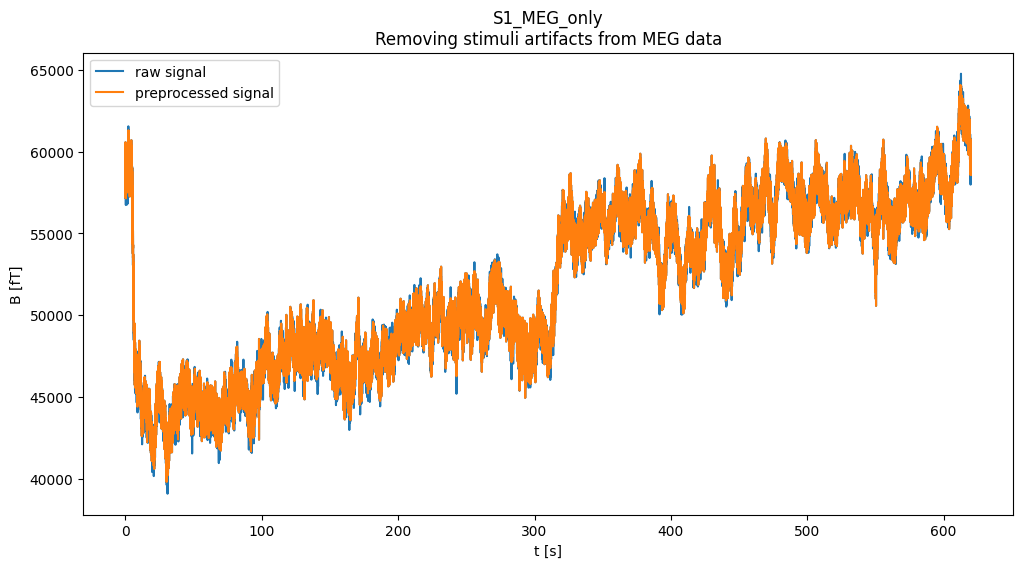

In [12]:
data = XEG_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='raw signal')

data = XEG_preprocessed_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='preprocessed signal')

plt_header('Removing stimuli artifacts from %s data' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig06.png


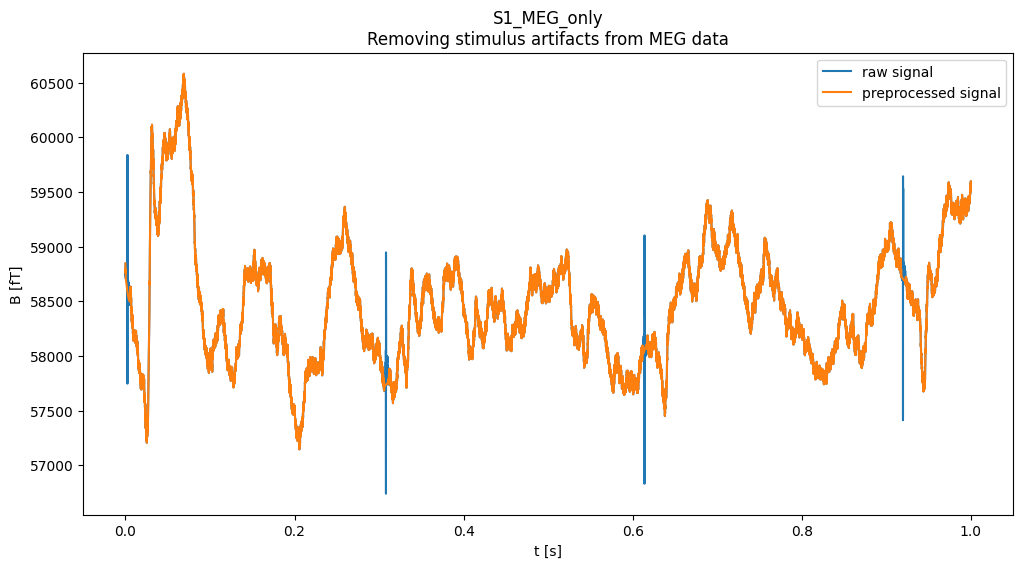

In [13]:
data = XEG_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='raw signal')

data = XEG_preprocessed_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='preprocessed signal')

plt_header('Removing stimulus artifacts from %s data' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig07.png


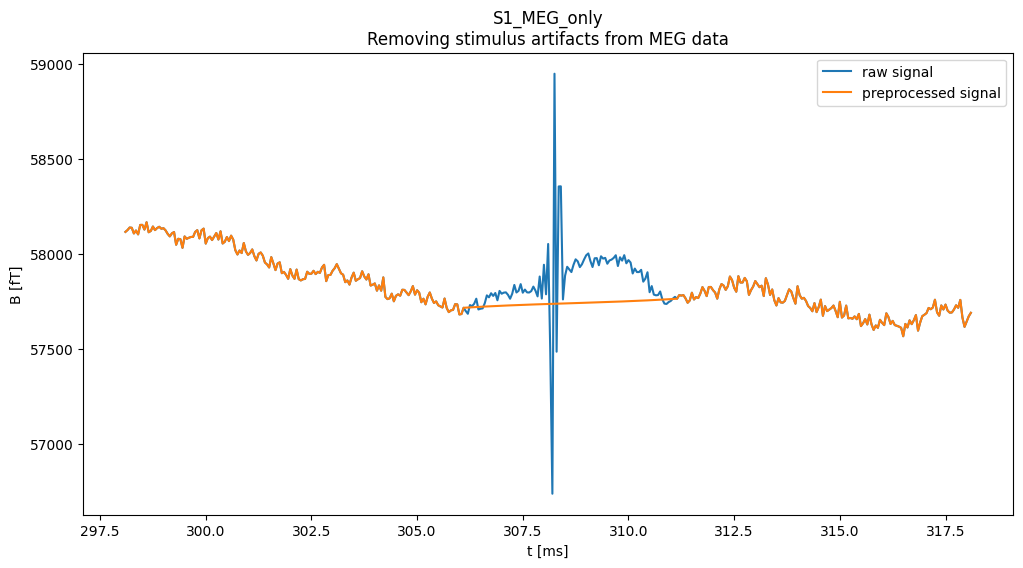

In [14]:
start_time = marker[0]/srate - 0.01 
end_time = marker[0]/srate + 0.01

data = XEG_data[int(start_time*srate):int(end_time*srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='raw signal')

data = XEG_preprocessed_data[int(start_time*srate):int(end_time*srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='preprocessed signal')

plt_header('Removing stimulus artifacts from %s data' % measurement_type)
plt.xlabel('t [ms]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

In [15]:
# apply fc=1Hz hp filter to remove DC component
sos = sig.butter(2, 1, 'highpass', fs=srate, output='sos')
XEG_preprocessed_hp_data = sig.sosfiltfilt(sos, XEG_preprocessed_data)
XEG_rest_hp_data = sig.sosfiltfilt(sos, XEG_rest_data)

--------------------
Fig08.png


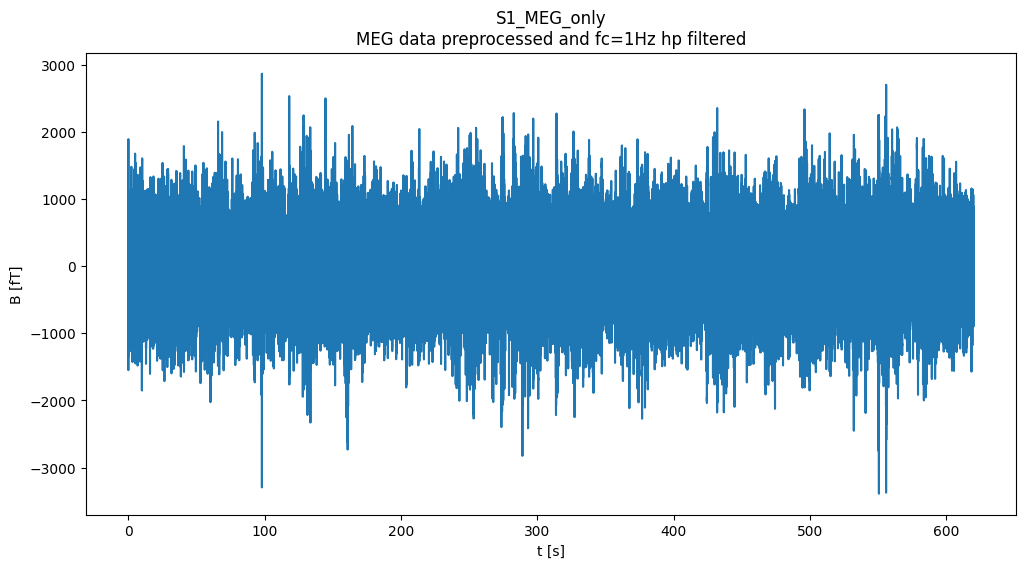

In [16]:
data = XEG_preprocessed_hp_data
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y)

plt_header('%s data preprocessed and fc=1Hz hp filtered' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt_show_save_fig()

In [17]:
# amplitude spectral density
def asd(data, nfft):

    yf, xf = mlab.psd(x=data, NFFT=nfft, Fs=srate, window=sig.windows.hann(nfft), noverlap=nfft//2)
    
    return xf, np.sqrt(yf)

--------------------
Fig_rest_clench_stim.png


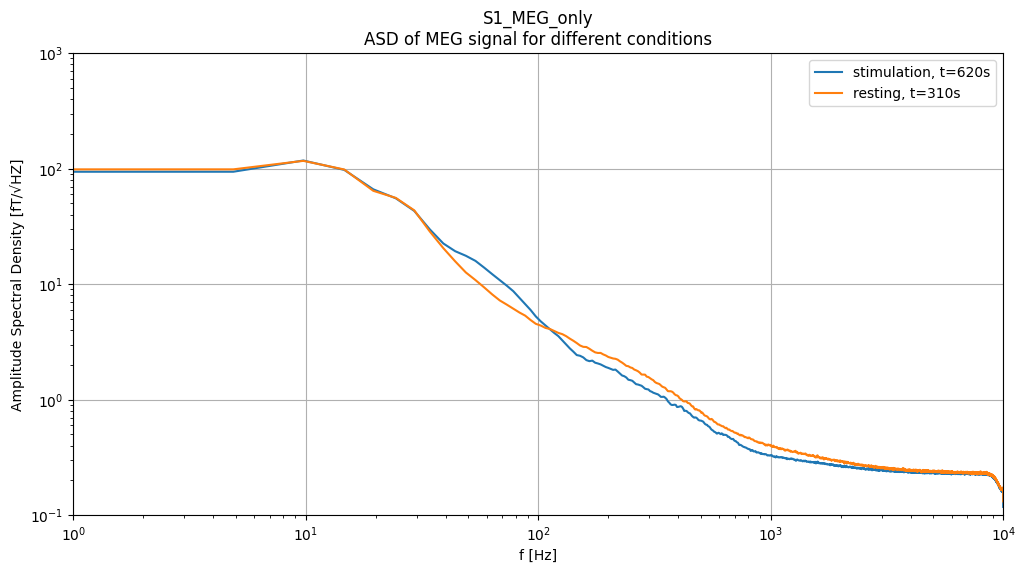

In [18]:
nfft = 2**(int(np.log2(srate))-2)

data = XEG_preprocessed_hp_data
xf, yf = asd(data, nfft)
plt.plot(xf, yf, label='stimulation, t=%ds' % (len(data)//srate))

data = XEG_rest_hp_data
xf, yf = asd(data, nfft)
plt.plot(xf, yf, label='resting, t=%ds' % (len(data)//srate))


plt_header('ASD of %s signal for different conditions' % measurement_type)
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
plt.ylim((1e-3,10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 10))
else:
    plt.ylim((0.1, 1000))
plt_show_save_fig('Fig_rest_clench_stim')

In [19]:
XEG_preprocessed_with_50Hz_data = XEG_preprocessed_hp_data

# For EEG data apply notch filter to remove powerline artifacts
if(measurement_type == 'MEG'):
     pass

elif(remove_powerline_filter_type == 'notch'):

    for i in range(50):
        powerline_freq = (2*i+1)*50
        b, a = sig.iirnotch(powerline_freq, powerline_freq/10, srate)
        XEG_preprocessed_hp_data = sig.filtfilt(b, a, XEG_preprocessed_hp_data)
    # interpolate the stimulus
    XEG_preprocessed_hp_data = meet.interpolateEEG(XEG_preprocessed_hp_data, all_stimuli, interpolate_win)

elif(remove_powerline_filter_type == 'PLI'):

    # For EEG data apply notch filter to remove powerline artifacts
    from helper_scripts.PLI import remove_PLI
    B = np.array([50,1,4])
    P = np.array([0.1,2.,5.])
    W = 3.

    for i in range(50):
        for j in range(3):
            powerline_freq = (2*i+1)*50
            XEG_preprocessed_hp_data = remove_PLI(
                XEG_preprocessed_hp_data, ac=powerline_freq, s_rate=srate, N_harmonics=1, B=B, P=P, W=W)
    # interpolate the stimulus
    XEG_preprocessed_hp_data = meet.interpolateEEG(XEG_preprocessed_hp_data, all_stimuli, interpolate_win)

elif(remove_powerline_filter_type == 'spectrum_notch'):

    import mne
    info = mne.create_info(ch_names=['ch1'], sfreq=srate, ch_types=['eeg'])
    raw = mne.io.RawArray([XEG_preprocessed_hp_data], info)

    powerline_freqs = []
    for i in range(50):
        powerline_freqs.append((2*i+1)*50)
    raw = raw.notch_filter(freqs=powerline_freqs, method="spectrum_fit")

    powerline_freqs = []
    for i in range(20):
        powerline_freqs.append((2*i+1)*50)
    raw = raw.notch_filter(freqs=powerline_freqs, method="spectrum_fit")
    XEG_preprocessed_hp_data = raw['ch1'][0][0]
    # interpolate the stimulus
    XEG_preprocessed_hp_data = meet.interpolateEEG(XEG_preprocessed_hp_data, marker, interpolate_win)

--------------------
Fig09.png


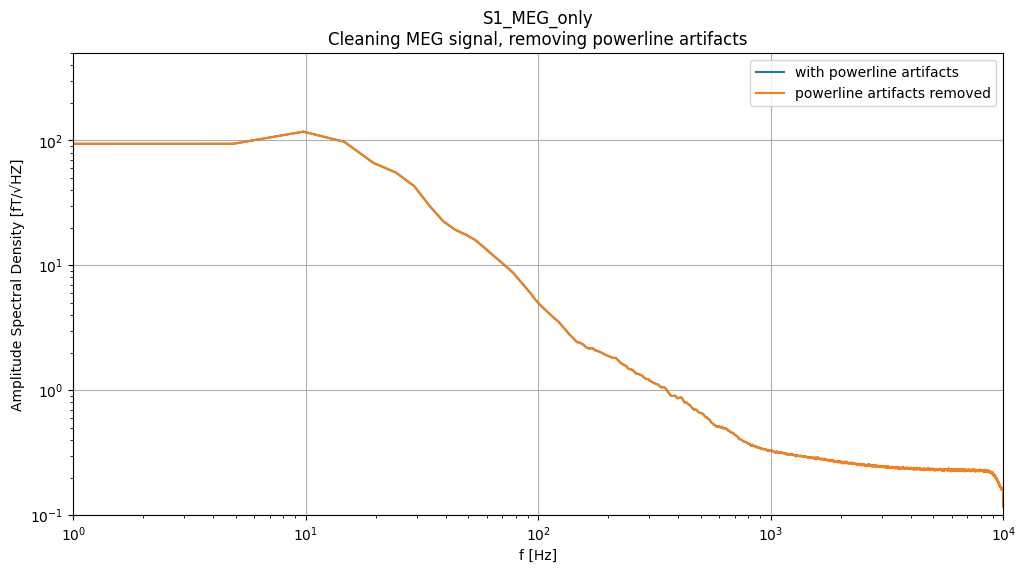

In [20]:
data = XEG_preprocessed_with_50Hz_data
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, removing powerline artifacts' % measurement_type)
plt.plot(xf, yf, label='with powerline artifacts')

data = XEG_preprocessed_hp_data
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='powerline artifacts removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 5))
else:
    plt.ylim((0.1, 500))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [21]:
# apply 450Hz-850Hz band-pass filter for sigma band extraction and removing outliers
lfreq_sigma = 450
rfreq_sigma = 850
sigma_freq_range_str = '%sHz-%sHz' % (lfreq_sigma, rfreq_sigma)

sigma_band_data = meet.iir.butterworth(XEG_preprocessed_hp_data, fs=(lfreq_sigma-50, rfreq_sigma+50),
                                        fp=(lfreq_sigma, rfreq_sigma), s_rate=srate)

In [22]:
# extract trials to remove outliers

whole_trial_len = int(np.round(np.mean(np.diff(all_stimuli))))
whole_trial_win_samples = [0,whole_trial_len]
whole_trial_t = (np.arange(whole_trial_win_samples[0], whole_trial_win_samples[1], 1)/float(srate)*1000)

XEG_preprocessed_hp_whole_trials = meet.epochEEG(XEG_preprocessed_hp_data, marker, whole_trial_win_samples)
XEG_preprocessed_with_50Hz_whole_trials = meet.epochEEG(XEG_preprocessed_with_50Hz_data, marker, whole_trial_win_samples)
sigma_band_whole_trials = meet.epochEEG(sigma_band_data, marker, whole_trial_win_samples)

sigma_win_ms = [10, 35]
sigma_win_samples = np.round(np.array(sigma_win_ms)/1000.*srate).astype(int)
sigma_burst_trials = meet.epochEEG(sigma_band_data, marker, sigma_win_samples)

--------------------
Fig10.png


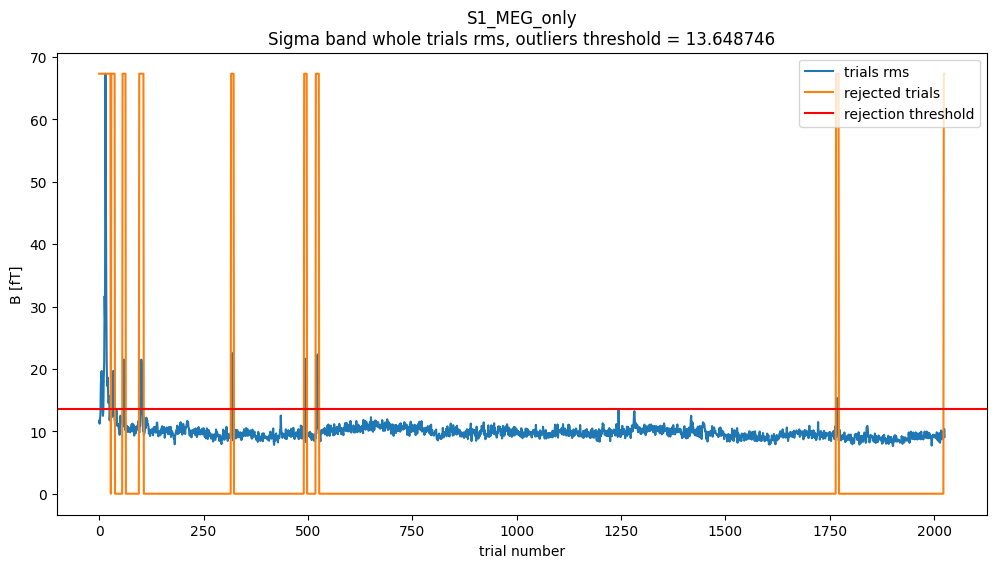

In [23]:
# calculate sigma band whole trials rms and percentiles to remove outliers

sigma_band_whole_trials_rms = np.sqrt(np.mean(sigma_band_whole_trials**2, axis=0))

sigma_band_whole_trials_rms_q25 = scipy.stats.scoreatpercentile(sigma_band_whole_trials_rms, 25)
sigma_band_whole_trials_rms_q50 = np.median(sigma_band_whole_trials_rms)
sigma_band_whole_trials_rms_q75 = scipy.stats.scoreatpercentile(sigma_band_whole_trials_rms, 75)
sigma_band_whole_trials_rms_iqr = sigma_band_whole_trials_rms_q75 - sigma_band_whole_trials_rms_q25

# set a high threshold to remove only very outliers
threshold_sigma_band_whole_trials_rms = sigma_band_whole_trials_rms_q75 + 3*sigma_band_whole_trials_rms_iqr

not_outliers_sigma_band = sigma_band_whole_trials_rms <= threshold_sigma_band_whole_trials_rms
not_outliers_sigma_band = np.convolve(not_outliers_sigma_band, np.ones(7)/7, mode='same')
not_outliers_sigma_band = (not_outliers_sigma_band > 0.999)

plt_header('Sigma band whole trials rms, outliers threshold = %f' % threshold_sigma_band_whole_trials_rms)
plt.plot(sigma_band_whole_trials_rms, label='trials rms')
plt.plot(-np.max(sigma_band_whole_trials_rms)*(not_outliers_sigma_band-1), label='rejected trials')
plt.axhline(threshold_sigma_band_whole_trials_rms, color='red', label='rejection threshold')
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend(loc='upper right')
plt_show_save_fig()

--------------------
Fig11.png


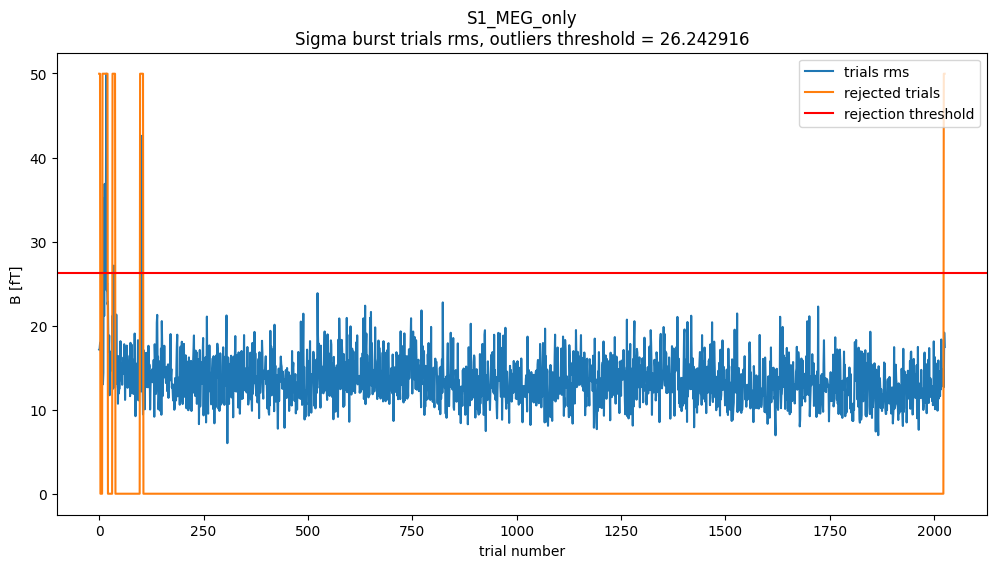

In [24]:
# calculate sigma burst rms and percentiles to remove outliers

sigma_burst_trials_rms = np.sqrt(np.mean(sigma_burst_trials**2, axis=0))

sigma_burst_rms_q25 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 25)
sigma_burst_rms_q50 = np.median(sigma_burst_trials_rms)
sigma_burst_rms_q75 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 75)
sigma_burst_iqr = sigma_burst_rms_q75 - sigma_burst_rms_q25

# set a high threshold to remove only very outliers
threshold_sigma_burst_rms = sigma_burst_rms_q75 + 3*sigma_burst_iqr

not_outliers_sigma_burst = sigma_burst_trials_rms <= threshold_sigma_burst_rms
not_outliers_sigma_burst = np.convolve(not_outliers_sigma_burst, np.ones(7)/7, mode='same')
not_outliers_sigma_burst = (not_outliers_sigma_burst > 0.999)

plt_header('Sigma burst trials rms, outliers threshold = %f' % threshold_sigma_burst_rms)
plt.plot(sigma_burst_trials_rms, label='trials rms')
plt.plot(-np.max(sigma_burst_trials_rms)*(not_outliers_sigma_burst-1), label='rejected trials')
plt.axhline(threshold_sigma_burst_rms, color='red', label='rejection threshold')
plt.xlabel('trial number')
plt.ylabel(unit)
plt.legend(loc='upper right')
plt_show_save_fig()

In [25]:
not_outliers = not_outliers_sigma_band*not_outliers_sigma_burst

XEG_preprocessed_hp_whole_trials = XEG_preprocessed_hp_whole_trials[:,not_outliers]
XEG_preprocessed_with_50Hz_whole_trials = XEG_preprocessed_with_50Hz_whole_trials[:,not_outliers]
sigma_band_whole_trials = sigma_band_whole_trials[:,not_outliers]
sigma_burst_trials = sigma_burst_trials[:,not_outliers]
sigma_band_whole_trials_rms = sigma_band_whole_trials_rms[not_outliers]
sigma_burst_trials_rms = sigma_burst_trials_rms[not_outliers]

In [26]:
print(XEG_preprocessed_hp_whole_trials.shape)
print(XEG_preprocessed_with_50Hz_whole_trials.shape)
print(sigma_band_whole_trials.shape)
print(sigma_burst_trials.shape)
print(sigma_band_whole_trials_rms.shape)
print(sigma_burst_trials_rms.shape)

(6115, 1937)
(6115, 1937)
(6115, 1937)
(500, 1937)
(1937,)
(1937,)


--------------------
Fig12.png


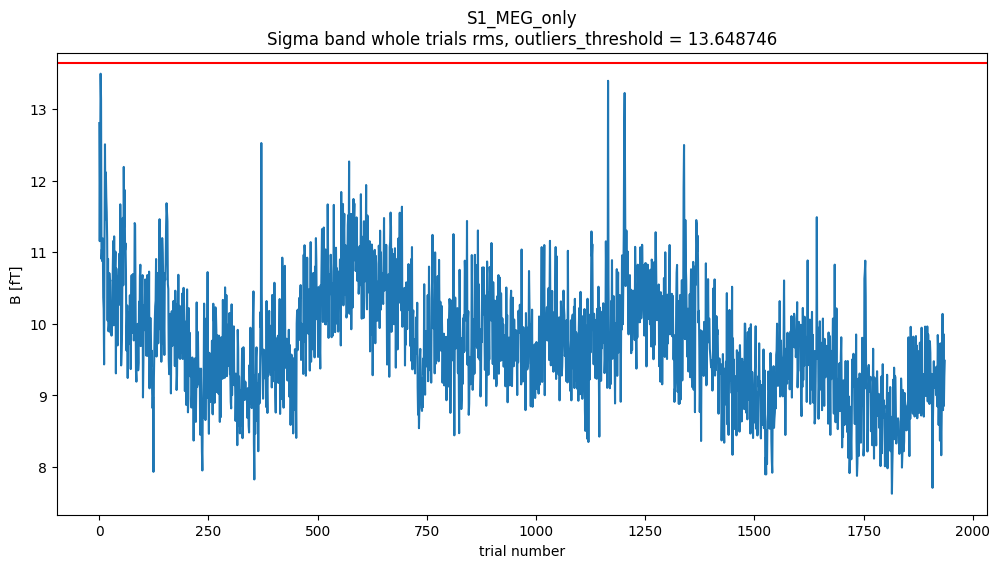

In [27]:
plt_header('Sigma band whole trials rms, outliers_threshold = %f' % threshold_sigma_band_whole_trials_rms)
plt.plot(sigma_band_whole_trials_rms)
plt.axhline(threshold_sigma_band_whole_trials_rms, color='red')
plt.xlabel('trial number')
plt.ylabel(unit)
plt_show_save_fig()

--------------------
Fig13.png


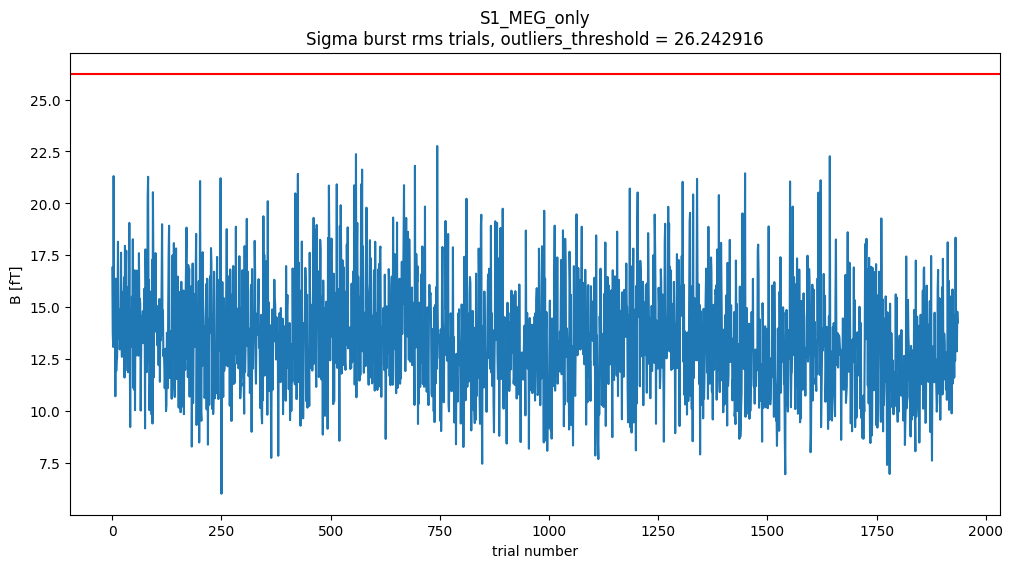

In [28]:
plt_header('Sigma burst rms trials, outliers_threshold = %f' % threshold_sigma_burst_rms)
plt.plot(sigma_burst_trials_rms)
plt.axhline(threshold_sigma_burst_rms, color='red')
plt.xlabel('trial number')
plt.ylabel(unit)
plt_show_save_fig()

In [29]:
XEG_preprocessed_hp_data_no_outliers = np.concatenate(XEG_preprocessed_hp_whole_trials.T)
XEG_preprocessed_with_50Hz_data_no_outliers = np.concatenate(XEG_preprocessed_with_50Hz_whole_trials.T)
all_stimuli_no_outliers = (np.arange(XEG_preprocessed_hp_whole_trials.shape[1])*XEG_preprocessed_hp_whole_trials.shape[0])
marker_no_outliers = all_stimuli_no_outliers[1:]
XEG_preprocessed_hp_data_no_outliers = meet.interpolateEEG(XEG_preprocessed_hp_data_no_outliers, marker_no_outliers, interpolate_win)
XEG_preprocessed_with_50Hz_data_no_outliers = meet.interpolateEEG(XEG_preprocessed_with_50Hz_data_no_outliers, marker_no_outliers, interpolate_win)

--------------------
Fig14.png


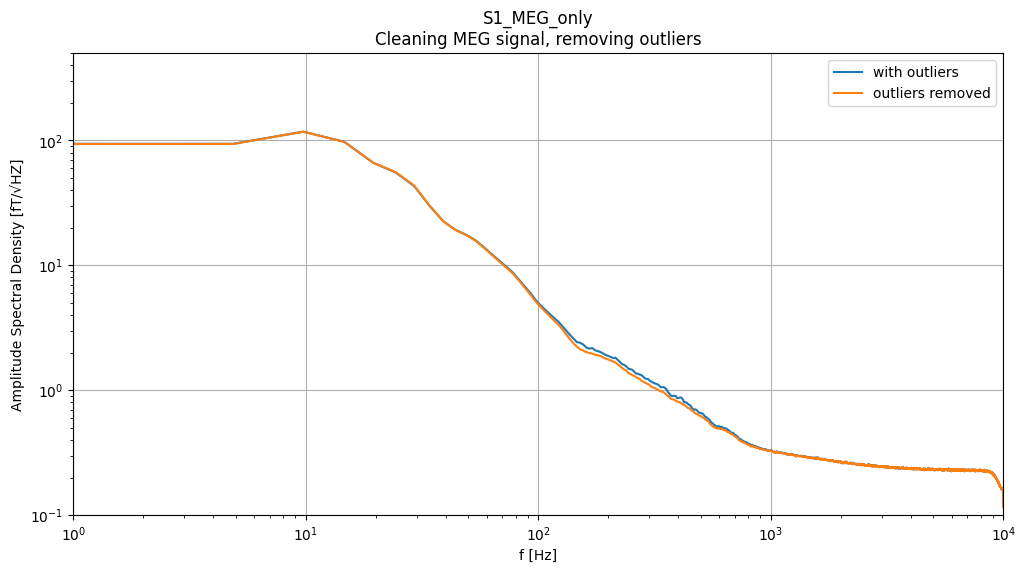

In [30]:
data = XEG_preprocessed_hp_data
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, removing outliers' % measurement_type)
plt.plot(xf, yf, label='with outliers')

data = XEG_preprocessed_hp_data_no_outliers
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='outliers removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((1e-3, 5))
else:
    plt.ylim((1e-1, 500))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

--------------------
Fig15.png


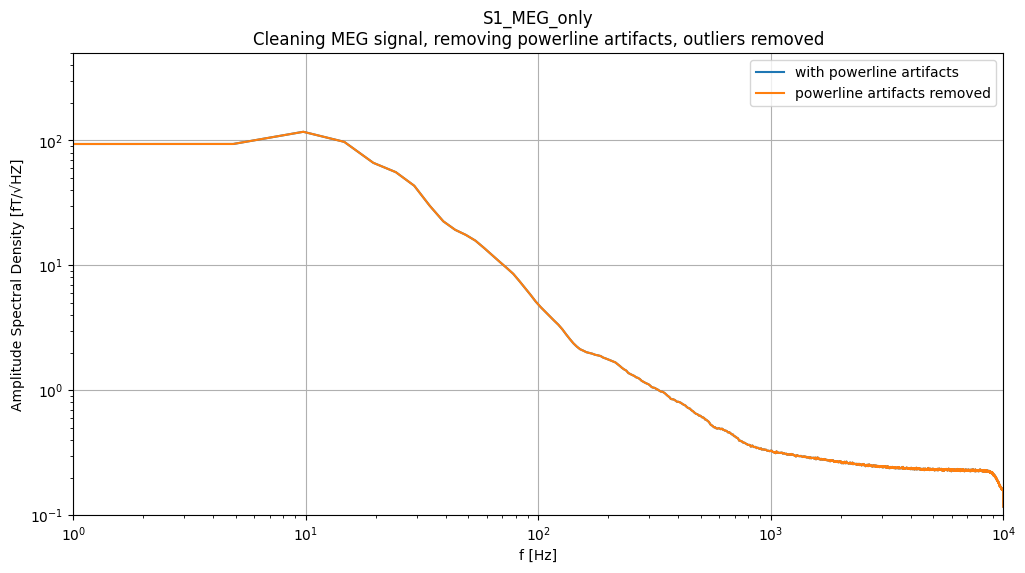

In [31]:
data = XEG_preprocessed_with_50Hz_data_no_outliers
nfft = 2**(int(np.log2(srate))-2)
xf, yf = asd(data, nfft)

plt_header('Cleaning %s signal, removing powerline artifacts, outliers removed' % measurement_type)
plt.plot(xf, yf, label='with powerline artifacts')

data = XEG_preprocessed_hp_data_no_outliers
xf, yf = asd(data, nfft)

plt.plot(xf, yf, label='powerline artifacts removed')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
if(measurement_type == 'EEG'):
    plt.ylim((0.001, 5))
else:
    plt.ylim((0.1, 500))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [32]:
XEG_preprocessed_hp_data = XEG_preprocessed_hp_data_no_outliers
all_stimuli = all_stimuli_no_outliers
marker = marker_no_outliers

In [33]:
XEG_whole_trials_mean = np.mean(XEG_preprocessed_hp_whole_trials, axis=-1)
XEG_preprocessed_hp_data_no_mean = np.concatenate(XEG_preprocessed_hp_whole_trials.T - XEG_whole_trials_mean)
XEG_preprocessed_hp_data_no_mean = meet.interpolateEEG(XEG_preprocessed_hp_data_no_mean, marker, interpolate_win)

--------------------
Fig16.png


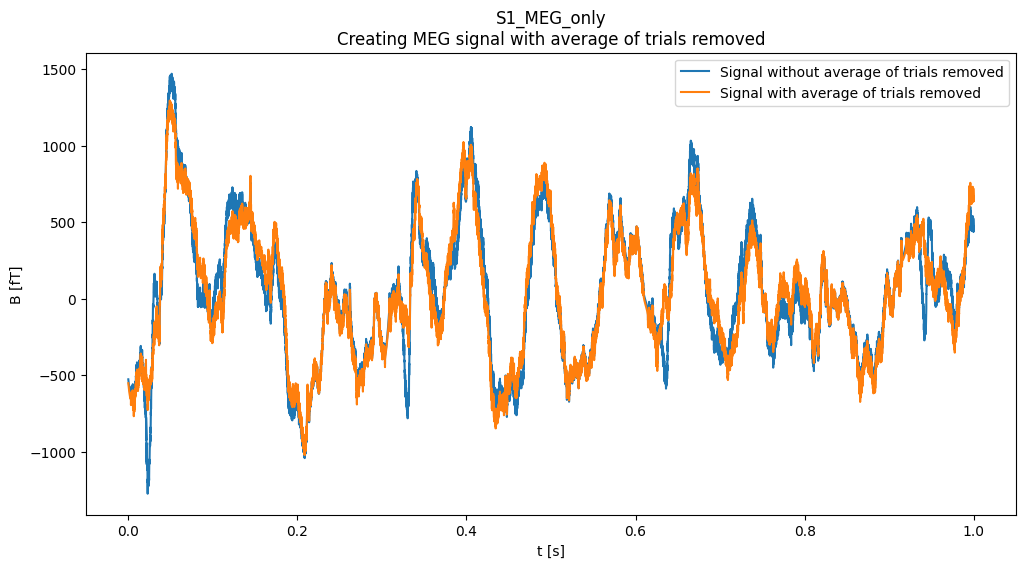

In [34]:
data = XEG_preprocessed_hp_data[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='Signal without average of trials removed')

data = XEG_preprocessed_hp_data_no_mean[:srate]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='Signal with average of trials removed')

plt_header('Creating %s signal with average of trials removed' % measurement_type)
plt.xlabel('t [s]')
plt.ylabel(unit)
plt.legend()
plt_show_save_fig()

--------------------
Fig17.png


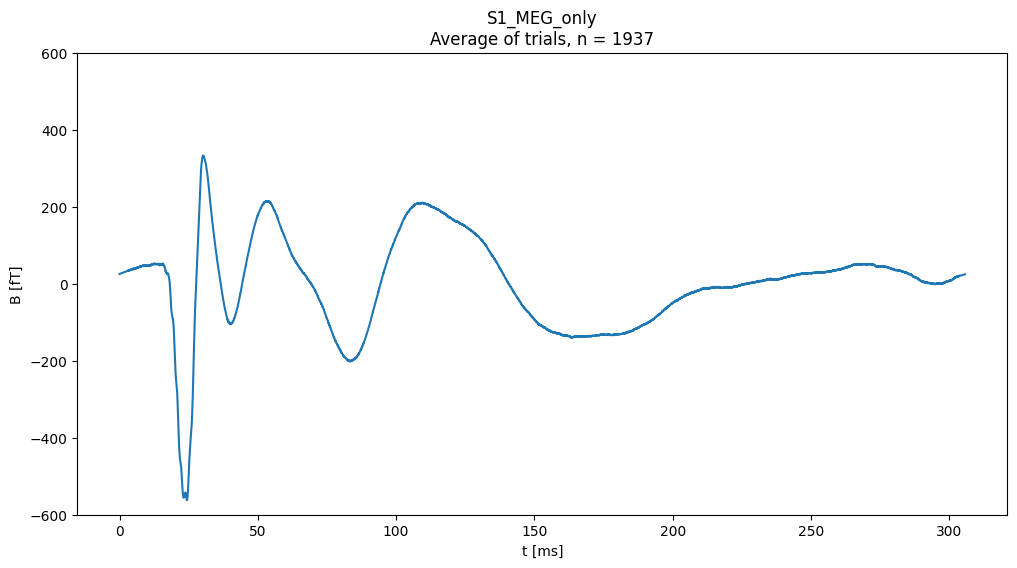

--------------------
Fig18.png


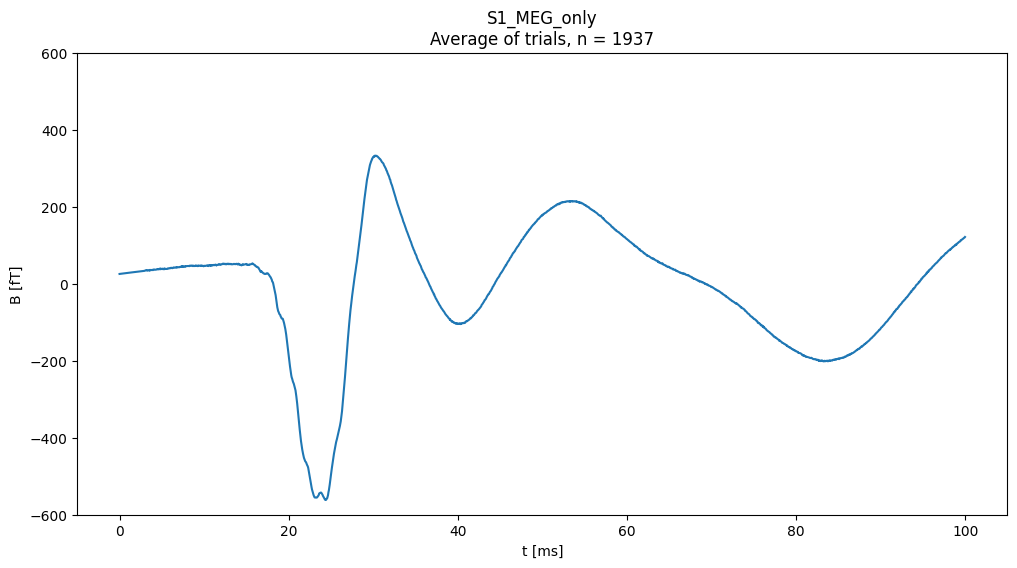

In [35]:
data = XEG_whole_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of trials, n = %d' % len(XEG_preprocessed_hp_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-6.5, 6.5))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

data = XEG_whole_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of trials, n = %d' % len(XEG_preprocessed_hp_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-5, 5))
else:
    plt.ylim((-600, 600))
plt_show_save_fig()

--------------------
Fig19.png


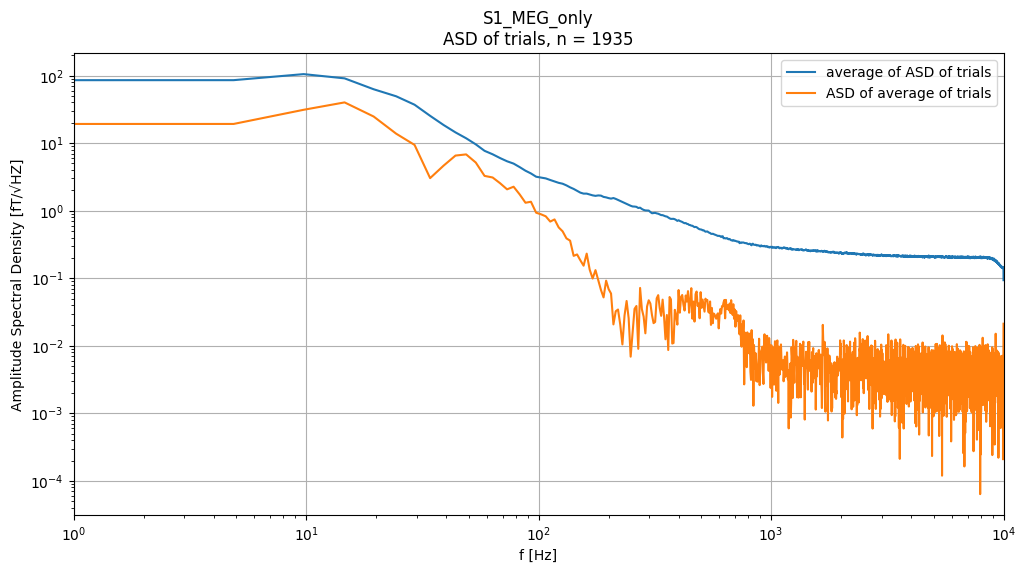

In [36]:
XEG_whole_trials = meet.epochEEG(XEG_preprocessed_hp_data, marker, whole_trial_win_samples)

data = XEG_whole_trials.T
nfft = 2**(int(np.log2(srate))-2)
asd_list = []
for trial in data:
    xf, yf = asd(trial, nfft)
    asd_list.append(yf)

asd_list = np.stack(asd_list)
plt.plot(xf, np.mean(asd_list, axis=0), label='average of ASD of trials')

plt_header('ASD of trials, n = %d' % len(XEG_whole_trials.T))

xf, yf = asd(np.mean(XEG_whole_trials, axis=-1), nfft)
plt.plot(xf, yf, label='ASD of average of trials')
plt.xscale('log')
plt.yscale('log')
plt.xlim((1,srate//2))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [37]:
# apply 30Hz-200Hz band-pass filter for N20 potential extraction
sos = sig.butter(2, [30, 200], 'bandpass', fs=srate, output='sos')
n20_response_data = sig.sosfiltfilt(sos, XEG_preprocessed_hp_data)
n20_response_trials = meet.epochEEG(n20_response_data, marker, whole_trial_win_samples)

--------------------
Fig20.png


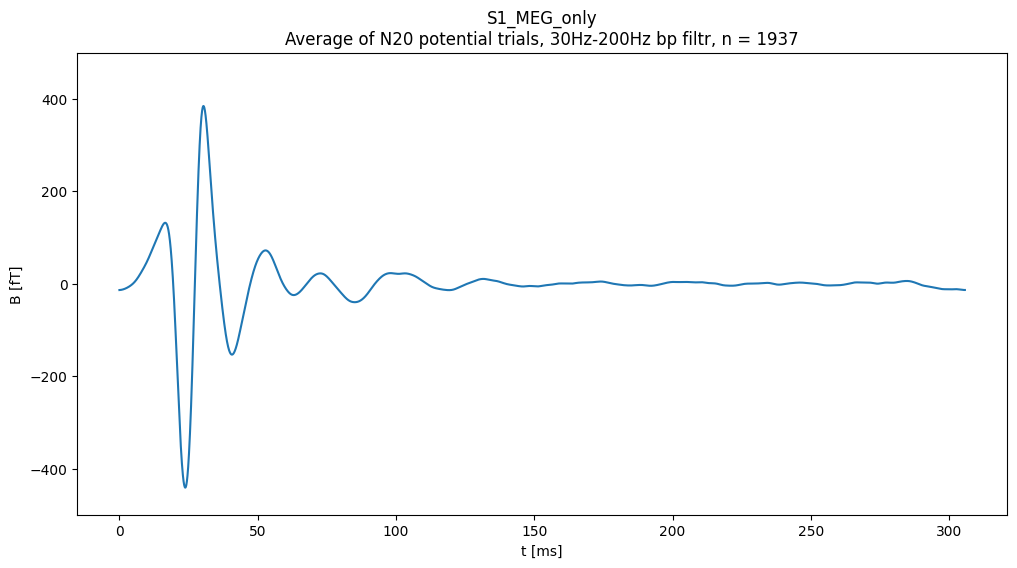

--------------------
Fig21.png


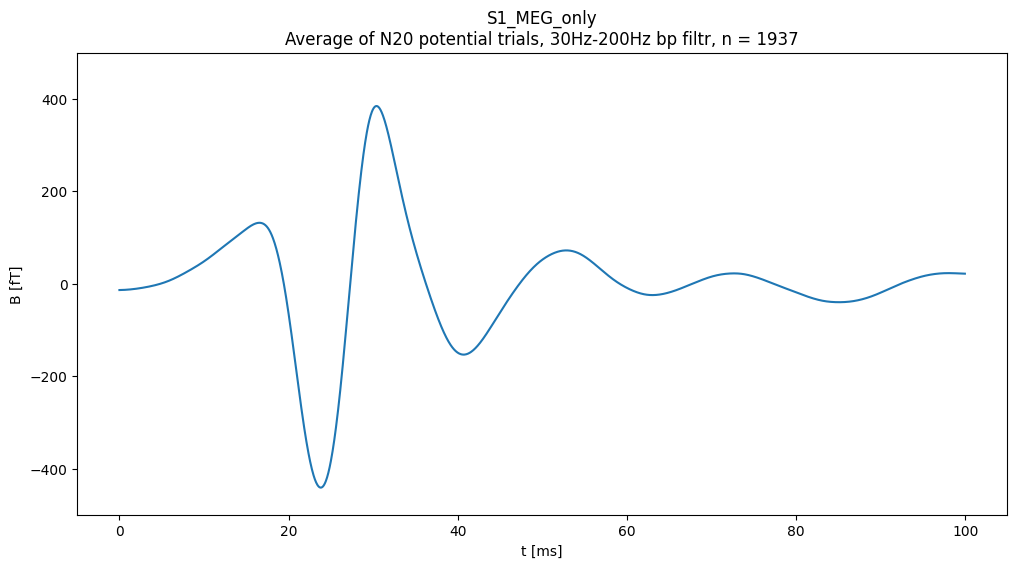

In [38]:
n20_response_trials_mean = np.mean(n20_response_trials, axis=-1)

data = n20_response_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of N20 potential trials, 30Hz-200Hz bp filtr, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-4, 4))
else:
    plt.ylim((-500, 500))
plt_show_save_fig()

data = n20_response_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of N20 potential trials, 30Hz-200Hz bp filtr, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-4, 4))
else:
    plt.ylim((-500, 500))
plt_show_save_fig()

--------------------
Fig22.png


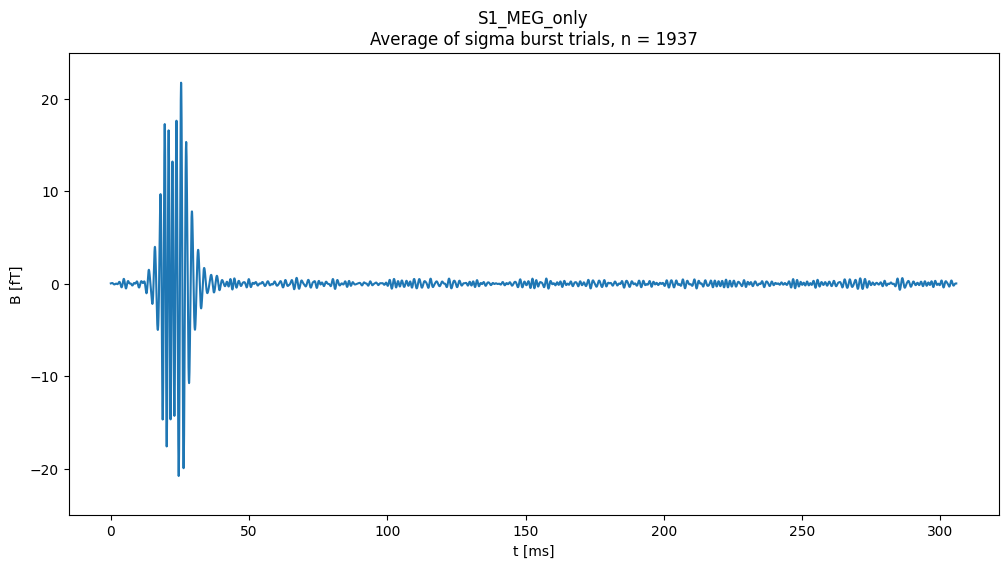

--------------------
Fig23.png


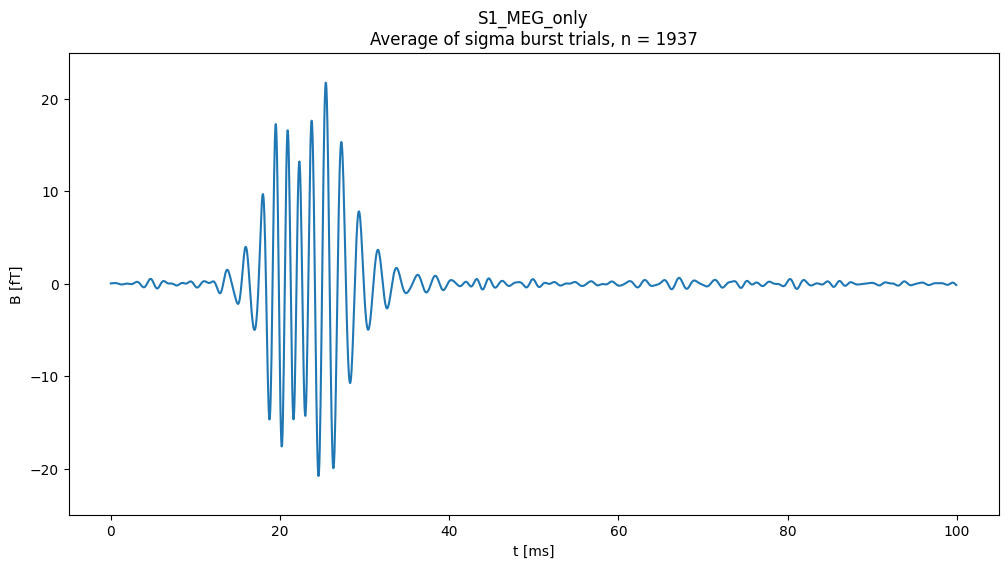

In [39]:
sigma_band_whole_trials_mean = np.mean(sigma_band_whole_trials, axis=-1)

data = sigma_band_whole_trials_mean
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of sigma burst trials, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-0.3, 0.3))
else:
    plt.ylim((-25, 25))
plt_show_save_fig()

data = sigma_band_whole_trials_mean[:srate//10]
data_x = np.linspace(0, (len(data)-1)/srate, len(data))*1000
data_y = data
plt.plot(data_x, data_y)
plt_header('Average of sigma burst trials, n = %d' % len(sigma_band_whole_trials.T))
plt.xlabel('t [ms]')
plt.ylabel(unit)
if(measurement_type == 'EEG'):
    plt.ylim((-0.3, 0.3))
else:
    plt.ylim((-25, 25))
plt_show_save_fig()

--------------------
Fig24.png


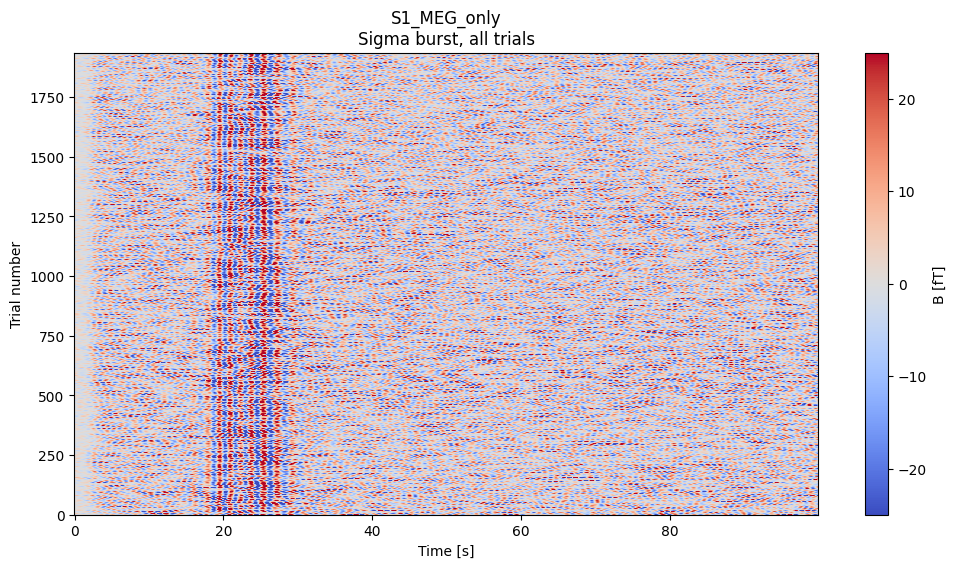

--------------------
Fig25.png


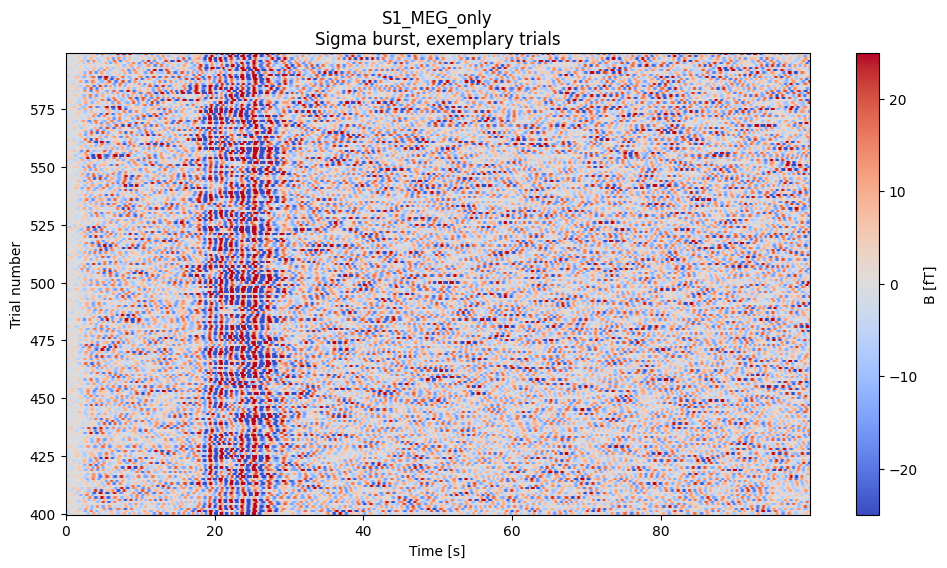

In [40]:
plt.rcParams['image.cmap'] = 'coolwarm'

plt_header('Sigma burst, all trials')
data = sigma_band_whole_trials[:srate//10,]
data_x = np.linspace(0, 1000*(len(data)-1)/srate, len(data))

if(measurement_type == 'MEG'):
    limit = 25
else:
    limit = 0.6 #np.sqrt(np.mean(data[len(data)//2:]**2))*2.8

plt.pcolormesh(data_x, np.arange(len(data.T)), data.T, vmin=-limit, vmax=limit)
plt.ylabel('Trial number')
plt.xlabel('Time [s]')
clb = plt.colorbar()
clb.set_label(unit)
plt_show_save_fig()

start_trial = 400
end_trial = 600
plt_header('Sigma burst, exemplary trials')
data = sigma_band_whole_trials[:srate//10,start_trial:end_trial]
data_x = np.linspace(0, 1000*(len(data)-1)/srate, len(data))

plt.pcolormesh(data_x, np.arange(start_trial, end_trial), data.T, vmin=-limit, vmax=limit)
plt.ylabel('Trial number')
plt.xlabel('Time [s]')
clb = plt.colorbar()
clb.set_label(unit)
plt_show_save_fig()

In [41]:
# create a custom sampling scheme for the S transform
def custom_sampling_meg(N):
    S_frange = [5, 5000]
    S_fnum = 30
    S_Nperperiod = 4
    wanted_freqs = np.exp(np.linspace(np.log(S_frange[0]),
        np.log(S_frange[1]), S_fnum))
    fftfreqs = np.fft.fftfreq(N, d=1./srate)
    # find the nearest frequency indices
    y = np.unique([np.argmin((w - fftfreqs)**2)
        for w in wanted_freqs])
    x = ((S_Nperperiod*fftfreqs[y]*N/float(srate))//2).astype(int)
    return x,y

--------------------
Fig26.png


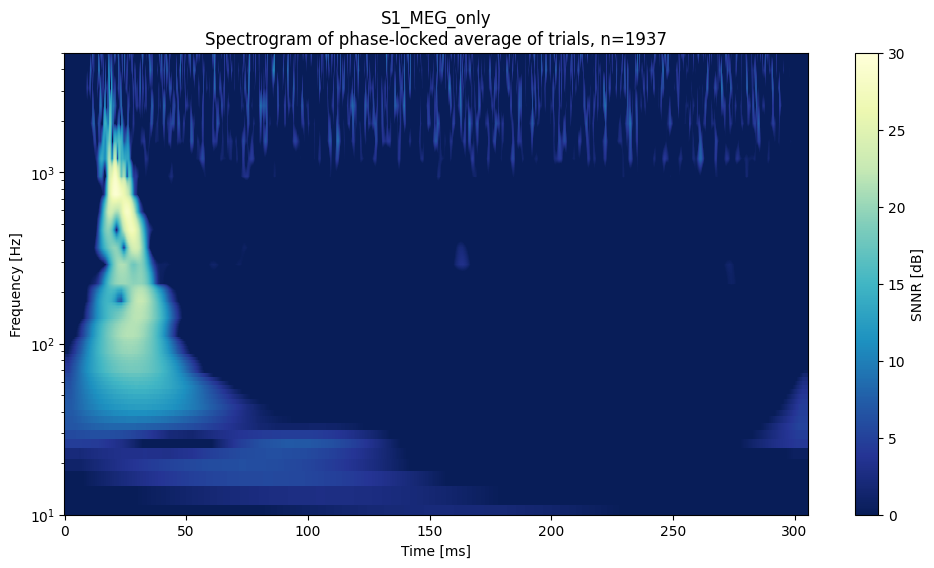

--------------------
Fig27.png


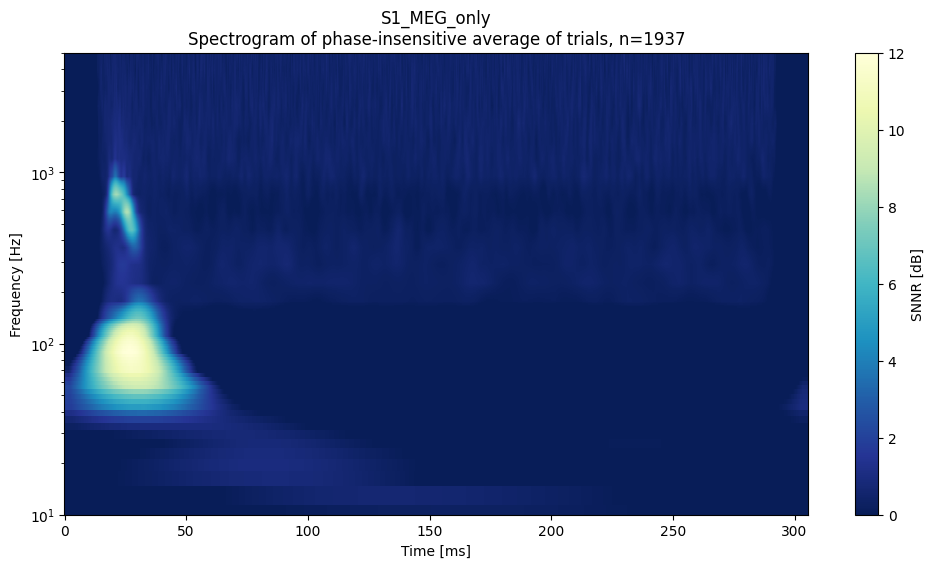

In [42]:
plt.rcParams['image.cmap'] = 'YlGnBu_r'

# get the frequency arrays
f = np.linspace(0, srate/2., len(whole_trial_t)//2)

#calculate the S-transforms
coords, tf = meet.tf.gft(XEG_preprocessed_hp_whole_trials, axis=0, sampling=custom_sampling_meg)

# interpolate onto a regular grid
s_transform_interp = meet.tf.interpolate_gft(
    coords, np.abs(np.mean(tf, axis=0)),
    IM_shape=(len(whole_trial_t)//2, len(whole_trial_t)),
    data_len=len(whole_trial_t),
    kindf='linear', kindt='linear')[-1]

s_transform_interp_dB = 20*np.log10((s_transform_interp.T/np.mean(s_transform_interp, axis=-1)).T)

plt_header('Spectrogram of phase-locked average of trials, n=%d' % XEG_preprocessed_hp_whole_trials.shape[-1])
plt.yscale('log')
plt.pcolormesh(whole_trial_t, f, s_transform_interp_dB, vmin=0, vmax=30)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
clb = plt.colorbar()
clb.set_label('SNNR [dB]')
#plt.ylim([1,srate//2])
plt.ylim([10,5000])
plt_show_save_fig()


# interpolate onto a regular grid
s_transform_interp = meet.tf.interpolate_gft(
    coords, np.mean(np.abs(tf), axis=0),
    IM_shape=(len(whole_trial_t)//2, len(whole_trial_t)),
    data_len=len(whole_trial_t),
    kindf='linear', kindt='linear')[-1]

s_transform_interp_dB = 20*np.log10((s_transform_interp.T/np.mean(s_transform_interp, axis=-1)).T)

plt_header('Spectrogram of phase-insensitive average of trials, n=%d' % XEG_preprocessed_hp_whole_trials.shape[-1])
plt.yscale('log')
if(measurement_type == 'EEG'):
    plt.pcolormesh(whole_trial_t, f, s_transform_interp_dB, vmin=0, vmax=3)
else:
    plt.pcolormesh(whole_trial_t, f, s_transform_interp_dB, vmin=0, vmax=12)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [ms]')
clb = plt.colorbar()
clb.set_label('SNNR [dB]')
#plt.ylim([1,srate//2])
plt.ylim([10,5000])
plt_show_save_fig()

In [43]:
stimulus_new = np.zeros(len(XEG_preprocessed_hp_data))
stimulus_new[marker_no_outliers] = 1.0

out_data = np.stack((XEG_preprocessed_hp_data, XEG_preprocessed_hp_data_no_mean, stimulus_new))
np.save(os.path.join(results_path, subject_name+'_cleaned_data.npy'), out_data)